In [1]:
import numpy as np

np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.linalg import norm
from skimage import measure
import networkx as nx
import time
import cv2
%matplotlib inline

In [72]:
psi_min = 30
psi_max = 90

search_area_size = 100

r_max = 1

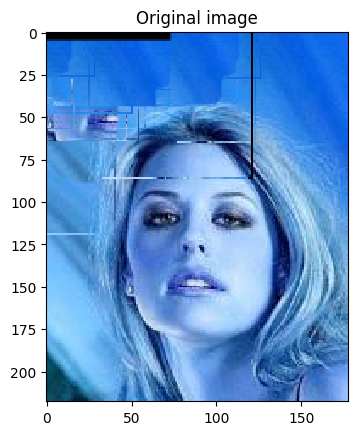

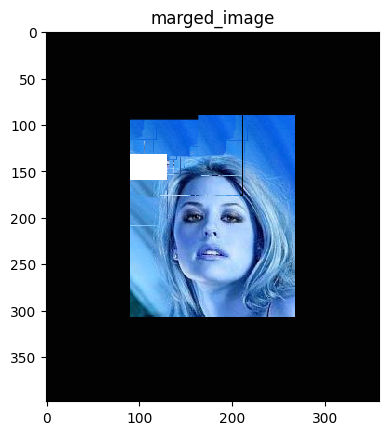

In [124]:
img = cv2.imread("result.png")
img.reshape((img.shape[0], img.shape[1], -1))
plt.imshow(img, interpolation='none', norm=Normalize(vmin=0, vmax=255))
plt.title("Original image")
plt.show()
shape = img.shape[2]

marged_img = (np.zeros((img.shape[0] + 2 * psi_max, img.shape[1] + 2 * psi_max, shape)) + 2).astype(int)
marged_img[psi_max: - psi_max, psi_max:-psi_max] = img.astype(int).copy()

marged_img[132:160, 90:130] = - np.ones(shape)

plt.imshow(marged_img.astype(np.uint8), interpolation='none', norm=Normalize(vmin=0, vmax=255))
plt.title("marged_image")
plt.show()

In [125]:
confidence = np.ones((marged_img.shape[0], marged_img.shape[1]))
confidence[marged_img[:, :, 0] == -1] = 0
confidence[(marged_img[:, :, 0] == 2) * (marged_img[:, :, 1] == 2) * (marged_img[:, :, 2] == 2)] = 0

In [126]:

def confidence_coefficient(confidence, pt, psi=9):
    result = 0
    for i in range(int(psi)):
        for j in range(int(psi)):
            result += confidence[int(pt[0] + i - (psi - 1) / 2 + 0.5), int(pt[1] + j - (psi - 1) / 2 + 0.5)]
    return float(result) / psi ** 2

def gen_normal_vector(omega):
    tangeantes = [(omega[i + 1][0] - omega[i - 1][0], omega[i + 1][1] - omega[i - 1][1]) for i in
                  range(1, len(omega) - 1)]
    normals = [(-j / np.sqrt(i * i + j * j), i / np.sqrt(i * i + j * j)) for i, j in tangeantes]
    return normals


def gen_data_vector(normal, isophote, alpha=255.):
    result = [np.abs(normal[i][0] * isophote[i][0] + normal[i][1] * isophote[i][1]) / alpha for i in
              range(len(isophote))]
    return result


def norm3d(img, param):
    temp = img.reshape((img.shape[0], img.shape[1], -1))
    shape = temp.shape[2]
    result = 0
    for i in range(shape):
        result += norm(img[:, :, i], param)
    return result

def distance(img1, img2, is_compared, gauss, param=2):
    temp = img1.reshape((img1.shape[0], img1.shape[1], -1))
    shape = temp.shape[2]
    result = 0

    for i in range(shape):
        result += norm((img1[:, :, i] - img2[:, :, i]) * gauss, param)
    return result

def create_kernel_local(xc, yc):
    result = np.zeros((int(psi), int(psi)))
    for i in range(int(psi)):
        for j in range(int(psi)):
            result[i, j] = float((i - xc) ** 2 + (j - yc) ** 2) / 2
    m = np.max(result)
    result = 1 - result.astype(np.float64) / m
    return result

def create_kernel_patch(is_compared):
    result = np.zeros(is_compared.shape)
    counter = 0
    for i in range(is_compared.shape[0]):
        for j in range(is_compared.shape[1]):
            if is_compared[i, j] == 0:
                res = create_kernel_local(i, j)
                result += res
                counter += 1
    result = result.astype(np.float64) / counter
    return result


def findbestmatch(patch, img, is_compared, patch_x, patch_y, psi=9):
    psi = int(psi)
    result = 9999
    gauss = create_kernel_patch(is_compared[:, :, 0])
    counter = 0
    for i in range(max(0, int(patch_x - search_area_size)), int(patch_x + search_area_size + 1)):
        for j in range(max(0, int(patch_y - search_area_size)), int(patch_y + search_area_size + 1)):
            for r in range(r_max):
                counter += 1
                if counter % 50000 == 0:
                    print("Counter %s" % counter)
                patch_comp = patch * is_compared
                if (i < psi / 2) | (j < psi / 2) | (i > img.shape[0] - psi / 2 - 1) | (j > img.shape[1] - psi / 2 - 1):
                    pass
                else:
                    img_comp = img[i - psi // 2: i + psi // 2 , j - psi // 2: j + psi // 2].copy()
                    img_comp = np.rot90(img_comp, r)
                    if np.all(img_comp[:, :, 0] != -1):
                        img_comp *= is_compared
                        if distance(img_comp, patch_comp, is_compared[:, :, 0], gauss) < result:
                            result = distance(img_comp, patch_comp, is_compared[:, :, 0], gauss)
                            result_x = i
                            result_y = j
                            result_r = r
    return result_x, result_y, result_r

def find_good_contour(contours, img):
    for contour in contours:
        pt = contour[len(contour) // 2]
        pt = [int(i) for i in pt]
        if np.any(img[pt[0] - 1:pt[0] + 2, pt[1] - 1:pt[1] + 2] == [-1, -1, -1]):
            contour = np.concatenate((np.array([contour[0]]), contour, np.array([contour[-1]])))
            contour = contour + 0.5
            return True, contour
    return False, []


def pooling(temp):
    return np.max(np.abs(temp))

def get_isophote(pts, img, psi=9):
    isophote = []
    for pt in pts:
        x = pt[0]
        y = pt[1]
        temp = img[np.int64(x - psi / 2): np.int64(x + psi / 2 + 1), np.int64(y - psi / 2): np.int64(y + psi / 2 + 1)]
        grad = np.gradient(np.ma.masked_where(temp == -1, temp))
        isophote.append((pooling(grad[0]), pooling(grad[1])))
    return isophote


def should_be_connected(n1, n2):
    if (len(n1) == 2) & (len(n2) == 2):
        return (((n1[0] - n2[0]) ** 2 + (n1[1] - n2[1]) ** 2) == 1)
    else:
        raise NameError("Wrong node")


def tuple_add(pt1, pt2):
    return (int(pt1[0] + pt2[0]), int(pt1[1] + pt2[1]))


def tuple_minus(pt1, pt2):
    return (pt1[0] - pt2[0], pt1[1] - pt2[1])


def edge_weight(pt1_ini, pt2_ini, old_patch, new_patch, demi=False):
    if demi:
        diff = tuple_minus(pt2_ini, pt1_ini)

        pt1 = (int(pt1_ini[0]), int(pt1_ini[1]))
        pt2 = tuple_add(pt2_ini, diff)
    else:
        pt1 = (int(pt1_ini[0]), int(pt1_ini[1]))
        pt2 = (int(pt2_ini[0]), int(pt2_ini[1]))

    return (norm3d(old_patch[pt1].reshape((1, 1, -1)) - new_patch[pt1].reshape((1, 1, -1)), 2) +
            norm3d(old_patch[pt2].reshape((1, 1, -1)) - new_patch[pt2].reshape((1, 1, -1)), 2))


def tuple_in(t, l):
    return (t in l) | ((t[1], t[0]) in l)


def create_graph(img_ini, pt_ini, new_patch, cut_edges, psi=9):
    img = img_ini.reshape((img_ini.shape[0], img_ini.shape[1], -1))
    pt = (int(pt_ini[0] + 0.5), int(pt_ini[1] + 0.5))
    old_patch = img[pt[0] - psi // 2 - 1: pt[0] + psi // 2 + 2, pt[1] - psi // 2 - 1: pt[1] + psi // 2 + 2]
    G = nx.Graph()
    G.add_node("old")
    G.add_node("new")
    for i in range(pt[0] - psi // 2, pt[0] + psi // 2 + 1):
        firsti = (i == pt[0] - psi / 2)
        lasti = (i == pt[0] + psi / 2)
        for j in range(pt[1] - psi // 2, pt[1] + psi // 2 + 1):
            firstj = (j == pt[1] - psi / 2)
            lastj = (j == pt[1] + psi / 2)
            if img[i, j, 0] != -1:
                G.add_node((i, j))
                if not firsti:
                    if ((img[i - 1, j, 0] == -1) & ((i - 1, j) not in G.nodes())):
                        G.add_node((i - 1, j))
                        G.add_edge((i - 1, j), 'new', weight=np.inf)
                else:
                    G.add_node((i - 1, j))
                    G.add_edge((i - 1, j), 'old', weight=np.inf)
                if not lasti:
                    if ((img[i + 1, j, 0] == -1) & ((i + 1, j) not in G.nodes())):
                        G.add_node((i + 1, j))
                        G.add_edge((i + 1, j), 'new', weight=np.inf)
                else:
                    G.add_node((i + 1, j))
                    G.add_edge((i + 1, j), 'old', weight=np.inf)
                if not firstj:
                    if ((img[i, j - 1, 0] == -1) & ((i, j - 1) not in G.nodes())):
                        G.add_node((i, j - 1))
                        G.add_edge((i, j - 1), 'new', weight=np.inf)
                else:
                    G.add_node((i, j - 1))
                    G.add_edge((i, j - 1), 'old', weight=np.inf)
                if not lastj:
                    if ((img[i, j + 1, 0] == -1) & ((i, j + 1) not in G.nodes())):
                        G.add_node((i, j + 1))
                        G.add_edge((i, j + 1), 'new', weight=np.inf)
                else:
                    G.add_node((i, j + 1))
                    G.add_edge((i, j + 1), 'old', weight=np.inf)

                for ibis, jbis in [(i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)]:
                    if (not tuple_in(((i, j), (ibis, jbis)), G.edges())) & ((ibis, jbis) in G.nodes()):
                        if ((i, j), (ibis, jbis)) in cut_edges:
                            idemi, jdemi = (float(i + ibis) / 2, float(j + jbis) / 2)
                            G.add_node((idemi, jdemi))
                            G.add_edge((idemi, jdemi), 'new', attr_dict=cut_edges)
                            G.add_edge((i, j), (idemi, jdemi),
                                       weight=edge_weight((i - pt[0] + psi / 2 + 1, j - pt[1] + psi / 2 + 1),
                                                          (idemi - pt[0] + psi / 2 + 1, jdemi - pt[1] + psi / 2 + 1),
                                                          old_patch, new_patch, demi=True))
                            G.add_edge((ibis, jbis), (idemi, jdemi),
                                       weight=edge_weight((ibis - pt[0] + psi / 2 + 1, jbis - pt[1] + psi / 2 + 1),
                                                          (idemi - pt[0] + psi / 2 + 1, jdemi - pt[1] + psi / 2 + 1),
                                                          old_patch, new_patch, demi=True))
                        else:
                            G.add_edge((ibis, jbis), (i, j),
                                       weight=edge_weight((i - pt[0] + psi / 2 + 1, j - pt[1] + psi / 2 + 1),
                                                          (ibis - pt[0] + psi / 2 + 1, jbis - pt[1] + psi / 2 + 1),
                                                          old_patch, new_patch))
    return G

def find_cut_edges(G, set_old, dico_cut_edges):
    list_just_cut = []
    for edge in G.edges(data=True):
        node1 = edge[0]
        node2 = edge[1]
        if (node1 != 'old') & (node1 != 'new') & (node2 != 'old') & (node2 != 'new'):
            if ((node1 in set_old) & (node2 not in set_old)) | ((node1 not in set_old) & (node2 in set_old)):
                if np.floor(node1[0]) != node1[0]:
                    node1 = (2 * node1[0] - node2[0], node1[1])
                elif np.floor(node1[1]) != node1[1]:
                    node1 = (node1[0], 2 * node1[1] - node2[1])
                elif np.floor(node2[0]) != node2[0]:
                    node2 = (2 * node2[0] - node1[0], node2[1])
                elif np.floor(node2[1]) != node2[1]:
                    node2 = (node2[0], 2 * node2[1] - node1[1])
                dico_cut_edges[(node1, node2)] = edge[2]["weight"]
                dico_cut_edges[(node2, node1)] = edge[2]["weight"]
                list_just_cut.append((node1, node2))
    return dico_cut_edges, list_just_cut


def update_cut_edges(cut_edges, new_set):
    new_cut_edges = {}
    for edge in cut_edges:
        node1 = edge[0]
        node2 = edge[1]
        if (node1 not in new_set) | (node2 not in new_set):
            new_cut_edges[edge] = cut_edges[edge]
    return new_cut_edges


def clean_mix(old_patch, new_patch, set_old, patch_x, patch_y, psi):
    applied_patch = new_patch.copy()
    for pt in set_old:
        if (pt != 'old'):
            if (np.int64(pt[0] - patch_x + psi / 2) >= 0) & (np.int64(pt[0] - patch_x + psi / 2) < psi) & \
                    (np.int64(pt[1] - patch_y + psi / 2) >= 0) & (np.int64(pt[1] - patch_y + psi / 2) < psi):
                applied_patch[np.int64(pt[0] - patch_x + psi / 2), np.int64(pt[1] - patch_y + psi / 2)] = \
                    old_patch[np.int64(pt[0] - patch_x + psi / 2), np.int64(pt[1] - patch_y + psi / 2)]
    return applied_patch


def blur_mix(img_ini, new_patch, enlarged_new_patch, set_old, just_cut_edges, patch_x, patch_y, psi):
    img = img_ini.reshape((img_ini.shape[0], img_ini.shape[1], -1))
    pt = (int(patch_x + 0.5), int(patch_y + 0.5))
    old_patch = img[pt[0] - psi // 2: pt[0] + psi // 2 + 1, pt[1] - psi // 2: pt[1] + psi // 2 + 1]
    enlarged_old_patch = img[pt[0] - psi // 2 - 1: pt[0] + psi // 2 + 2, pt[1] - psi // 2 - 1: pt[1] + psi // 2 + 2]
    applied_patch = img[pt[0] - psi // 2 - 1: pt[0] + psi // 2 + 2, pt[1] - psi // 2 - 1: pt[1] + psi // 2 + 2]
    applied_patch[1:-1, 1:-1] = clean_mix(old_patch, new_patch, set_old, patch_x, patch_y, psi)
    for edge in just_cut_edges:
        node1 = edge[0]
        node2 = edge[1]
        value11, value12 = np.int64(node1[0] - patch_x + psi / 2 + 1), np.int64(node1[1] - patch_y + psi / 2 + 1)
        value21, value22 = np.int64(node2[0] - patch_x + psi / 2 + 1), np.int64(node2[1] - patch_y + psi / 2 + 1)
        if node1 in set_old:
            applied_patch[value11, value12] = 0.66 * enlarged_old_patch[value11, value12] + 0.34 * enlarged_new_patch[
                value11, value12]
            applied_patch[value21, value22] = 0.34 * enlarged_old_patch[value21, value22] + 0.66 * enlarged_new_patch[
                value21, value22]
        else:
            applied_patch[value11, value12] = 0.34 * enlarged_old_patch[value11, value12] + 0.66 * enlarged_new_patch[
                value11, value12]
            applied_patch[value21, value22] = 0.66 * enlarged_old_patch[value21, value22] + 0.34 * enlarged_new_patch[
                value21, value22]
    return applied_patch[1:-1, 1:-1]

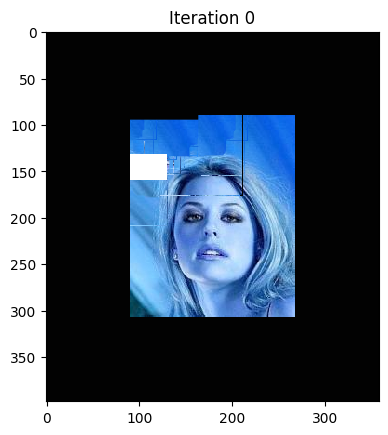

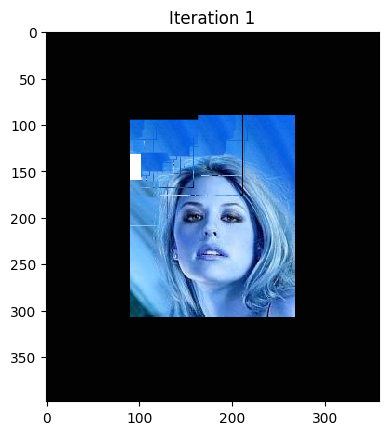

Done in 42.70977592468262 seconds


In [127]:
time_init = time.time()
contours = measure.find_contours(marged_img[:, :, 0], 0.8)
criteria, contour = find_good_contour(contours, marged_img)
nb_iter = 0
cut_edges = {}

while criteria:

    plt.imshow(marged_img.astype(np.uint8), norm=Normalize(vmin=0, vmax=255), interpolation='none')
    plt.title("Iteration " + str(nb_iter))
    plt.show()
    nb_iter += 1

    psi = np.random.randint(psi_min, psi_max) // 2 * 2
    psi = int(psi)

    omega = [(i[0], i[1]) for i in contour]

    confidence_vector = [confidence_coefficient(confidence, pt, psi=int(psi)) for pt in omega][1:-1]

    isophote_vector = get_isophote(omega, marged_img)[1:-1]

    normal_vector = gen_normal_vector(omega)

    data_vector = gen_data_vector(normal_vector, isophote_vector, alpha=10.)

    priority_vector = [data_vector[i] * confidence_vector[i] for i in range(len(data_vector))]

    m = max(priority_vector)
    indices = [i for i, j in enumerate(priority_vector) if j == m]
    indice = indices[len(indices) // 2]
    patch_x, patch_y = omega[indice + 1]

    patch_x = int(patch_x + 0.5)
    patch_y = int(patch_y + 0.5)

    patch = marged_img[np.int64(patch_x - psi / 2): np.int64(patch_x + psi / 2),
            np.int64(patch_y - psi / 2): np.int64(patch_y + psi / 2)]

    is_compared = marged_img[np.int64(patch_x - psi / 2): np.int64(patch_x + psi / 2),
                  np.int64(patch_y - psi / 2): np.int64(patch_y + psi / 2)] != -1

    result_x, result_y, result_r = findbestmatch(patch, marged_img, is_compared, patch_x, patch_y, psi=psi + 1)

    true_patch = marged_img[result_x - psi // 2: result_x + psi // 2 + 1,
                 result_y - psi // 2: result_y + psi // 2 + 1].copy()
    true_patch = np.rot90(true_patch, result_r)
    enlarged_true_patch = marged_img[result_x - psi // 2 - 1: result_x + psi // 2 + 2,
                          result_y - psi // 2 - 1: result_y + psi // 2 + 2].copy()
    enlarged_true_patch = np.rot90(enlarged_true_patch, result_r)

    G = create_graph(marged_img, (patch_x, patch_y), enlarged_true_patch, cut_edges, psi=int(psi))
    sets = (nx.minimum_cut(G, 'old', 'new', capacity="weight"))

    if 'old' in sets[1][0]:
        set_old = sets[1][0]
        set_new = sets[1][1]
    else:
        set_old = sets[1][1]
        set_new = sets[1][0]

    cut_edges, just_cut_edges = find_cut_edges(G, set_old, cut_edges)

    cut_edges = update_cut_edges(cut_edges, set_new)

    applied_patch = blur_mix(marged_img, true_patch, enlarged_true_patch, set_old, just_cut_edges, patch_x, patch_y,
                             int(psi))

    marged_img[np.int64(patch_x - psi / 2 + 0.5): np.int64(patch_x + psi / 2 + 1 + 0.5),
    np.int64(patch_y - psi / 2 + 0.5): np.int64(patch_y + psi / 2 + 1 + 0.5)] = applied_patch

    m = confidence_vector[indice]
    confidence[np.int64(patch_x - psi / 2): np.int64(patch_x + psi / 2 + 1),
    np.int64(patch_y - psi / 2): np.int64(patch_y + psi / 2 + 1)] = m
    contours = measure.find_contours(marged_img[:, :, 0], 0.8)
    criteria, contour = find_good_contour(contours, marged_img)

time_taken = time.time() - time_init
print("Done in %s seconds" % time_taken)


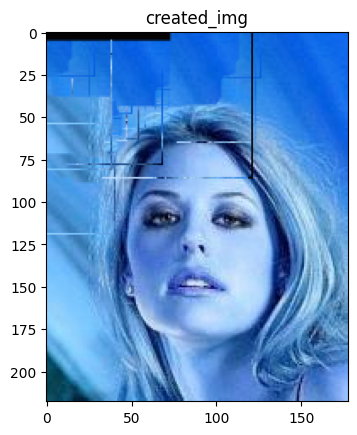

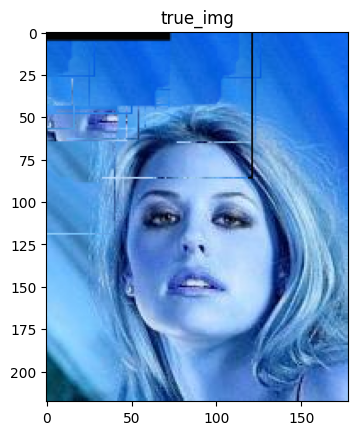

In [128]:
result = marged_img[psi_max:-psi_max, psi_max:-psi_max].copy().astype(np.uint8)
plt.imshow(result)
plt.title("created_img")
plt.show()
plt.imshow(img)
plt.title("true_img")
plt.show()

In [129]:
cv2.imwrite("result.png", result)

True